20221025-182456


## Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import re
import math
from datetime import datetime
import time
from collections import OrderedDict
from functools import partial
sys.dont_write_bytecode = True
from IPython.core.debugger import set_trace

In [3]:
import json
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
from typing import Any,List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from tqdm import tqdm

In [4]:
# import for webcrawling
import bs4
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse
import requests

## Import ReprLearn and TileMani packages

In [5]:
import reprlearn as rl

In [6]:
from reprlearn.visualize.utils import get_fig, show_timg, show_timgs, show_npimgs, show_batch, make_grid_from_tensors
from reprlearn.utils.misc import info, now2str, today2str, get_next_version_path, n_iter_per_epoch


## Set Path 
1. Add project root and src folders to `sys.path`


In [7]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)
# now can use modules in `src` folder: e.g.,
# from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler
# from src.data.transforms.functional import unnormalize

Project root:  /data/hayley-old/DCPDownloader
Src folder:  /data/hayley-old/DCPDownloader/src
This nb path:  /data/hayley-old/DCPDownloader/nbs

/data/hayley-old/DCPDownloader added to the path.


In [8]:
# ROOT = Path("/data/hayley-old/Tenanbaum2000")
# DATA_ROOT = Path("/data/hayley-old/Tenanbaum2000/data")
# MAP_DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")

data_root = Path("/data/datasets")
real_data_dir = Path("/data/datasets/reverse-eng-data/originals/CelebA/img_align_celeba")
print("data_root: ", str(data_root))
print("real_data_root  (original celeba): ", str(real_data_dir))
print(real_data_dir.exists())

data_root:  /data/datasets
real_data_root  (original celeba):  /data/datasets/reverse-eng-data/originals/CelebA/img_align_celeba
False


## Import src

In [9]:
from src.report import DCPReport, is_valid_img_tag

## Helpers

In [10]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    """src:https://www.peterbe.com/plog/best-practice-with-retries-with-requests
    """
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [11]:
def parse_lat_lng(soup: bs4.BeautifulSoup) -> Dict[str, Union[int, bool]]:
    
    meta_tags = soup.head.find_all('meta')
    
    lat, lng = None, None
    for meta_tag in meta_tags:
        attr_name = meta_tag.attrs.get('name')
        if attr_name is None:
            continue
        if attr_name == 'latitude':
            lat = meta_tag.attrs.get('content')
        if attr_name == 'longitude':
            lng = meta_tag.attrs.get('content')
   
    visit_idx = parse_visit_idx(soup)
    
    return {'lat': lat, 
            'lng': lng, 
            'visited': not lat is None, 
            'visit_idx': visit_idx}

In [12]:
def parse_visit_idx(soup: bs4.BeautifulSoup) -> int:
    
    try:
        title_str = soup.head.title.contents[0]
        # 'DCP (visit #3)'
        pos = title_str.find('#') + 1
        return title_str[pos]
    except:
        return -1
    


## Test - Main


In [13]:
# select visit_id
# vid = 0
# vid = 1 # 43n, 72w --> lat: 43, lng: -72
# vid = 2
# vid = 6800 #53n 84e --> lat: 55, lng: 84
vid = 6900

# create report object
report = DCPReport(vid)

# r = requests_retry_session().get(report.report_url)
# soup = bs4.BeautifulSoup(r.text, 'html.parser')

In [14]:
report.info()

vid:  6900
was visited:  False
lat:  None
lng:  None
visit_idx:  None
text:  


In [15]:
#test: download all images for this report
out_dir = Path('./temp')


In [16]:
report.img_page_url

'https://confluence.org/photo.php?visitid=6900&pic=ALL'

In [ ]:
report.download_imgs(out_dir, filter_func=is_valid_img_tag)

In [ ]:
report.img_urls


## Test - Download images from multiple visit_ids


In [220]:
out_dir = Path('./temp')

visit_ids = range(0,10)
for vid in visit_ids:
    report = DCPReport(vid)
    report.download_imgs(out_dir, filter_func=is_valid_img_tag)


Done: downloaded 0 imgs for visit_id 0...
Done: downloaded 4 imgs for visit_id 1...
Done: downloaded 5 imgs for visit_id 2...
Done: downloaded 1 imgs for visit_id 3...
Done: downloaded 5 imgs for visit_id 4...
Download failed. Passing this url: https://confluence.org/us/ct/n42w072/%70%69%63%31.jpg...
Done: downloaded 4 imgs for visit_id 5...
Done: downloaded 5 imgs for visit_id 6...
Done: downloaded 5 imgs for visit_id 7...
8 has not been visited. Pass.
Done: downloaded 5 imgs for visit_id 9...


## Main - Download all images from the first visit (id=0) to the latest (visit_id=22980)

In [ ]:
out_dir = Path('./outs')
out_dir.mkdir(exist_ok=True)


# visit_ids = range(0,22981)
visit_ids = range(574,22981)

for vid in visit_ids:
    print('Downloading vid: ', vid)
    try:
        report = DCPReport(vid)
        report.download_imgs(out_dir, filter_func=is_valid_img_tag)
    
    except:
        continue

Done: downloaded 6 imgs for visit_id 574...
Done: downloaded 6 imgs for visit_id 575...
576 has not been visited. Pass.
Done: downloaded 3 imgs for visit_id 577...
Done: downloaded 5 imgs for visit_id 578...
579 has not been visited. Pass.
580 has not been visited. Pass.
581 has not been visited. Pass.
582 has not been visited. Pass.
583 has not been visited. Pass.
Done: downloaded 5 imgs for visit_id 584...
585 has not been visited. Pass.
586 has not been visited. Pass.
587 has not been visited. Pass.
588 has not been visited. Pass.
589 has not been visited. Pass.
590 has not been visited. Pass.
591 has not been visited. Pass.
Done: downloaded 4 imgs for visit_id 592...
593 has not been visited. Pass.
Done: downloaded 4 imgs for visit_id 594...
595 has not been visited. Pass.
Download failed. Passing this url: https://confluence.org/us/or/n43w124/%70%69%63%32.jpg...
Download failed. Passing this url: https://confluence.org/us/or/n43w124/%70%69%63%33.jpg...
Done: downloaded 9 imgs for 

# todo: 20221025-195557

- resume with image url download code integration

## Playground

In [ ]:
meta_tags = soup.head.find_all('meta')
lat_tag = meta_tags[1]
lng_tag = meta_tags[2]
lat_tag, lng_tag

In [ ]:
# lat_tag.attrs


In [ ]:
parse_lat_lng(soup) 

In [ ]:
len(soup.body.table.find_all('table'))

In [ ]:
table_tags = soup.body.table.find_all('table')
descr_table = table_tags[-1]
descr_table.div.contents

In [ ]:
date_tag = descr_table.div.b #todo: parse to get a st
date_tag

In [ ]:
date_str = descr_table.div.b.contents[0] #todo: use regex to parse dd-mm-yyyy
print('date str: ', date_str)


In [ ]:
def parse_date(soup) -> str:
    table_tags = soup.body.table.find_all('table')
    descr_table = table_tags[-1]
    
    date_str = descr_table.div.b.contents[0] #todo: use regex to parse dd-mm-yyyy
    # todo:
    
    return date_str

In [ ]:
def parse_report_text(soup) -> str:
    table_tags = soup.body.table.find_all('table')
    descr_table = table_tags[-1]
    
    text = ''
    for para_str in descr_table.div.stripped_strings:
        text += para_str
    return text

In [ ]:
#test
report_text = parse_report_text(descr_table)
report_text

In [ ]:
# parse visit index


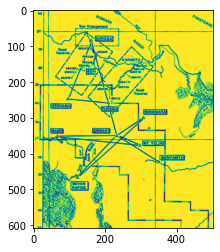

In [20]:
img_fp = Path('/data/hayley-old/DCPDownloader/nbs/outs/5745_49_-117_ripple-ridge-cabins-info.jpg')
img_fp = Path('/data/hayley-old/DCPDownloader/nbs/outs/11956_-7_146_location-map.jpg')


img = np.array(Image.open(img_fp))
plt.imshow(img)

In [21]:
img.shape

(608, 503)

In [ ]:
img